<a href="https://colab.research.google.com/github/Kanaieu/deteksi-7-bunga-cnn/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [7 Spesies Bunga](https://www.kaggle.com/datasets/nadyana/flowers/data)
- **Nama:** Muhammad Tsaqiif Ash-Shiddiq
- **Email:** muhammadtsaqiif.ash@gmail.com
- **ID Dicoding:** muhammadtsaqiifash

## Import Semua Packages/Library yang Digunakan

In [3]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [4]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadtsaqiifa","key":"1572ef8a163b81d1b96bbe808a6d053f"}'}

In [7]:
!rm -rf flowers/

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d nadyana/flowers
!unzip flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/lotus/lotusnvevin.jpg  
  inflating: flowers/lotus/louts-flower-pond-close-up-petals-stamin-lotus-lily-144696984.jpg  
  inflating: flowers/lotus/macro-lotus-flower-13214393.jpg  
  inflating: flowers/lotus/macro-pink-lotus-flower-macro-pink-lotus-flower-close-up-pink-lotus-flower-raining-sunlight-morning-159065830.jpg  
  inflating: flowers/lotus/maxresdefault1.jpg  
  inflating: flowers/lotus/micro_-shot_-of_-a_-white_-lotus_-flower_-micro_-shot_-of_-a_-white_-lotus_-flower_-with_-green_-159427226.jpg  
  inflating: flowers/lotus/national_flower_inner.jpg  
  inflating: flowers/lotus/ndsfgiw.png  
  inflating: flowers/lotus/nelumbo-nucifera-flower-also-known-as-indian-lotus-sacred-lotus-bean-india-egyptian-bean-simply-lotus-nelumbo-nucifera-143764558.jpg  
  inflating: flowers/lotus/nelumbo_2.jpg  
  inflating: flowers/lotus/nlevnwoejr.jpg  
  inflating: flowers/lotus/p9ihfe5f.png  
  inflating: flowers/lotus/pex

**Plot gambar sampel untuk semua kelas**

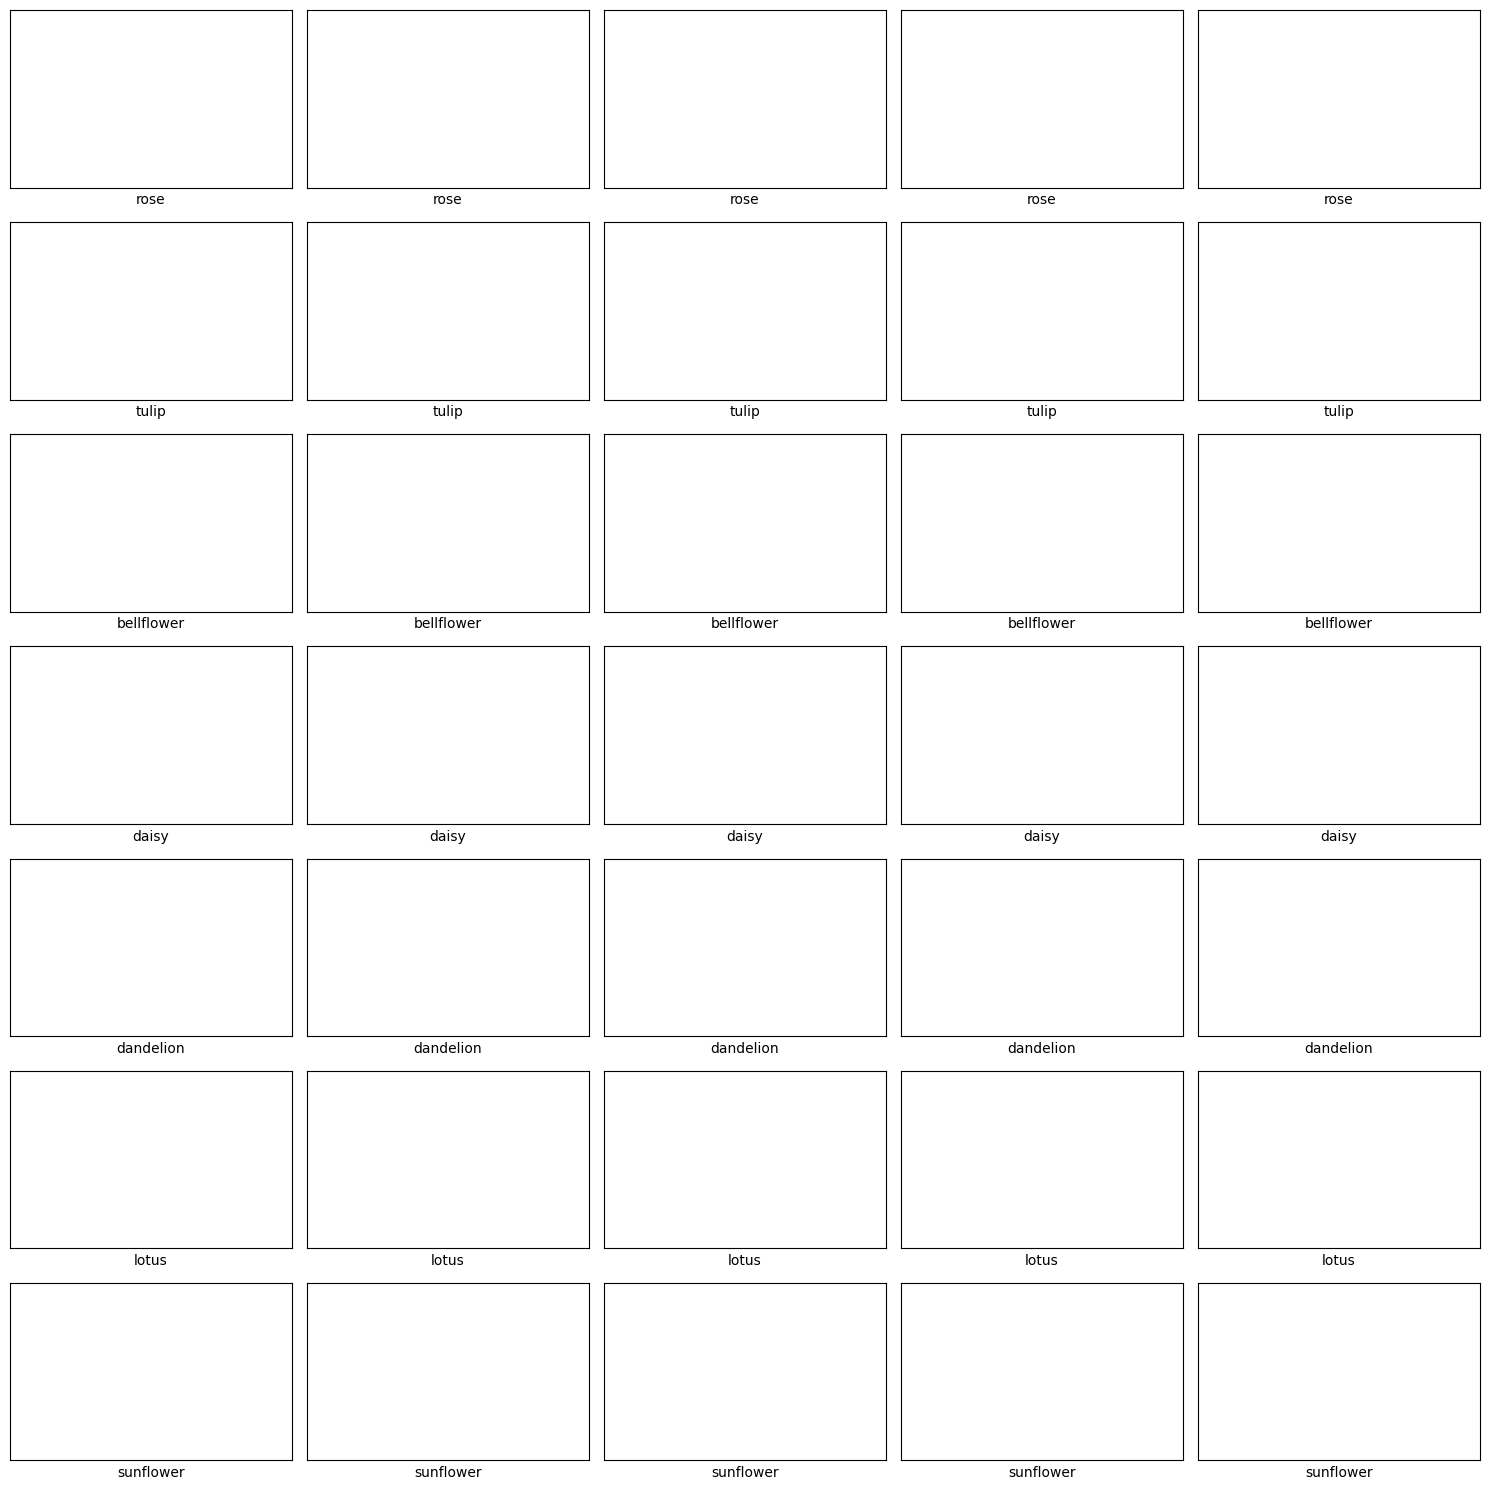

In [10]:
lung_image = {}

path = "flowers/"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot distribusi gambar di seluruh kelas**

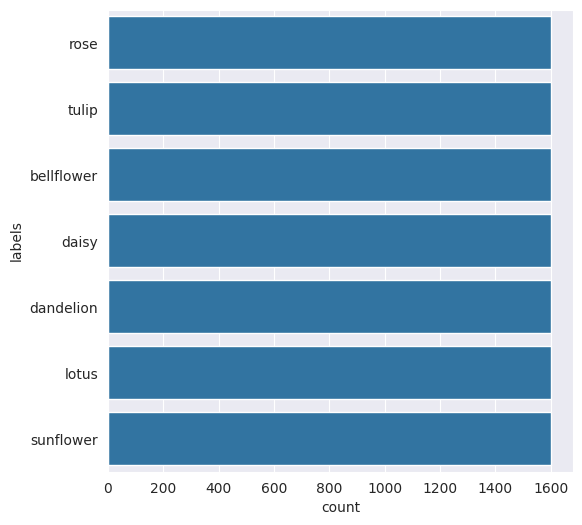

In [11]:
lung_path = "flowers/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'flowers/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
bellflower,1600
daisy,1600
dandelion,1600
lotus,1600
rose,1600
sunflower,1600
tulip,1600


In [13]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Menggunakan Stratify agar penyebaran seimbang**

In [14]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

train size 8960
test size 2240


In [15]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels    
test   bellflower     320
       daisy          320
       dandelion      320
       lotus          320
       rose           320
       sunflower      320
       tulip          320
train  bellflower    1280
       daisy         1280
       dandelion     1280
       lotus         1280
       rose          1280
       sunflower     1280
       tulip         1280
dtype: int64 


                                                    path labels    set
7340             flowers/lotus/national_flower_inner.jpg  lotus  train
1737           flowers/rose/15190665092_5c1c37a066_m.jpg   rose  train
10874  flowers/rose/white-roses-four-bouquet-blossom-...   rose   test
2760   flowers/tulip/7aad619dfddfaff5756747b235ec1e3e...  tulip  train
8540            flowers/rose/white-roses-blue-431385.jpg   rose  train


In [16]:
datasource_path = "flowers/"
dataset_path = "Dataset-Final/"

In [17]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [18]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_bellflower = os.path.join(TRAIN_DIR, 'bellflower')
train_daisy = os.path.join(TRAIN_DIR, 'daisy')
train_dandelion = os.path.join(TRAIN_DIR, 'dandelion')
train_lotus = os.path.join(TRAIN_DIR, 'lotus')
train_rose = os.path.join(TRAIN_DIR, 'rose')
train_sunflower = os.path.join(TRAIN_DIR, 'sunflower')
train_tulip = os.path.join(TRAIN_DIR, 'tulip')

test_bellflower = os.path.join(TEST_DIR, 'bellflower')
test_daisy = os.path.join(TEST_DIR, 'daisy')
test_dandelion = os.path.join(TEST_DIR, 'dandelion')
test_lotus = os.path.join(TEST_DIR, 'lotus')
test_rose = os.path.join(TEST_DIR, 'rose')
test_sunflower = os.path.join(TEST_DIR, 'sunflower')
test_tulip = os.path.join(TEST_DIR, 'tulip')

print("Total number of bellflower images in training set: ", len(os.listdir(train_bellflower)))
print("Total number of daisy images in training set: ", len(os.listdir(train_daisy)))
print("Total number of dandelion images in training set: ", len(os.listdir(train_dandelion)))
print("Total number of lotus images in training set: ", len(os.listdir(train_lotus)))
print("Total number of rose images in training set: ", len(os.listdir(train_rose)))
print("Total number of sunflower images in training set: ", len(os.listdir(train_sunflower)))
print("Total number of tulips images in training set: ", len(os.listdir(train_tulip)))

print("Total number of bellflower images in test set: ", len(os.listdir(test_bellflower)))
print("Total number of daisy images in test set: ", len(os.listdir(test_daisy)))
print("Total number of dandelion images in test set: ", len(os.listdir(test_dandelion)))
print("Total number of lotus images in test set: ", len(os.listdir(test_lotus)))
print("Total number of rose images in test set: ", len(os.listdir(test_rose)))
print("Total number of sunflower images in test set: ", len(os.listdir(test_sunflower)))
print("Total number of tulips images in test set: ", len(os.listdir(test_tulip)))

Total number of bellflower images in training set:  1280
Total number of daisy images in training set:  1280
Total number of dandelion images in training set:  1280
Total number of lotus images in training set:  1280
Total number of rose images in training set:  1280
Total number of sunflower images in training set:  1280
Total number of tulips images in training set:  1280
Total number of bellflower images in test set:  320
Total number of daisy images in test set:  320
Total number of dandelion images in test set:  320
Total number of lotus images in test set:  320
Total number of rose images in test set:  320
Total number of sunflower images in test set:  320
Total number of tulips images in test set:  320


In [19]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='sparse',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='validation',
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse',
    subset=None,
    shuffle=False
)

Found 7168 images belonging to 7 classes.
Found 1792 images belonging to 7 classes.
Found 2240 images belonging to 7 classes.


## Modelling

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [21]:
from tensorflow.keras import regularizers
model_32 = Sequential([
    # 1st Convolutional Block
    # Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.0005))
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(32, (4, 4), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Dense + Dropout layers
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.3),

    # Output layer
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model_32.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [23]:
print(model_32.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,288,007 (12.54 MB)

 Trainable params: 3,287,815 (12.54 MB)

 Non-trainable params: 192 (768.00 B)

None


In [24]:
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', target=0.85, patience=5):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.monitor = monitor
        self.target = target
        self.patience = patience
        self.wait = 0
        self.stopping_triggered = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)

        if current is None:
            return

        if current >= self.target:
            if not self.stopping_triggered:
                self.stopping_triggered = True
                self.wait = 0

            else:
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training: {self.monitor} sudah >= {self.target} dan patience {self.patience} habis.")
                self.wait += 1
        else:
            self.wait = 0

In [28]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_accuracy = EarlyStoppingAtAccuracy(monitor='val_accuracy', target=0.85, patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_lr=1e-6)

In [29]:
history_32 = model_32.fit(
    train_generator,
    epochs=40,
    batch_size=16,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_accuracy, reduce_lr]
)

Epoch 1/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2322 - loss: 6.3244
Epoch 1: val_accuracy improved from -inf to 0.21094, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 141s 579ms/step - accuracy: 0.2324 - loss: 6.3222 - val_accuracy: 0.2109 - val_loss: 5.3477 - learning_rate: 1.0000e-04
Epoch 2/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.3328 - loss: 4.7811
Epoch 2: val_accuracy improved from 0.21094 to 0.39565, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 126s 565ms/step - accuracy: 0.3328 - loss: 4.7798 - val_accuracy: 0.3956 - val_loss: 3.9662 - learning_rate: 1.0000e-04
Epoch 3/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3805 - loss: 3.8796
Epoch 3: val_accuracy improved from 0.39565 to 0.53292, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 555ms/step - accuracy: 0.3805 - loss: 3.8789 - val_accuracy: 0.5329 - val_loss: 3.2259 - learning_rate: 1.0000e-04
Epoch 4/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.4135 - loss: 3.3965
Epoch 4: val_accuracy improved from 0.53292 to 0.57701, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 557ms/step - accuracy: 0.4135 - loss: 3.3961 - val_accuracy: 0.5770 - val_loss: 2.8326 - learning_rate: 1.0000e-04
Epoch 5/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.4564 - loss: 3.0385
Epoch 5: val_accuracy did not improve from 0.57701
224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 557ms/step - accuracy: 0.4565 - loss: 3.0383 - val_accuracy: 0.5753 - val_loss: 2.5924 - learning_rate: 1.0000e-04
Epoch 6/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4800 - loss: 2.8025
Epoch 6: val_accuracy improved from 0.57701 to 0.62500, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 554ms/step - accuracy: 0.4801 - loss: 2.8024 - val_accuracy: 0.6250 - val_loss: 2.4122 - learning_rate: 1.0000e-04
Epoch 7/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.5073 - loss: 2.6207
Epoch 7: val_accuracy did not improve from 0.62500
224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 557ms/step - accuracy: 0.5073 - loss: 2.6206 - val_accuracy: 0.6021 - val_loss: 2.3276 - learning_rate: 1.0000e-04
Epoch 8/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5192 - loss: 2.5280
Epoch 8: val_accuracy improved from 0.62500 to 0.65346, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 554ms/step - accuracy: 0.5192 - loss: 2.5278 - val_accuracy: 0.6535 - val_loss: 2.1721 - learning_rate: 1.0000e-04
Epoch 9/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5417 - loss: 2.4046
Epoch 9: val_accuracy improved from 0.65346 to 0.66239, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 145s 647ms/step - accuracy: 0.5417 - loss: 2.4045 - val_accuracy: 0.6624 - val_loss: 2.0684 - learning_rate: 1.0000e-04
Epoch 10/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5571 - loss: 2.2805
Epoch 10: val_accuracy improved from 0.66239 to 0.66350, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 553ms/step - accuracy: 0.5571 - loss: 2.2805 - val_accuracy: 0.6635 - val_loss: 1.9794 - learning_rate: 1.0000e-04
Epoch 11/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5715 - loss: 2.2147
Epoch 11: val_accuracy improved from 0.66350 to 0.66685, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 146s 652ms/step - accuracy: 0.5715 - loss: 2.2147 - val_accuracy: 0.6669 - val_loss: 1.9536 - learning_rate: 1.0000e-04
Epoch 12/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5816 - loss: 2.1406
Epoch 12: val_accuracy did not improve from 0.66685
224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 557ms/step - accuracy: 0.5816 - loss: 2.1406 - val_accuracy: 0.6507 - val_loss: 1.8961 - learning_rate: 1.0000e-04
Epoch 13/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5993 - loss: 2.0523
Epoch 13: val_accuracy improved from 0.66685 to 0.67411, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 127s 568ms/step - accuracy: 0.5993 - loss: 2.0524 - val_accuracy: 0.6741 - val_loss: 1.8347 - learning_rate: 1.0000e-04
Epoch 14/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6002 - loss: 2.0109
Epoch 14: val_accuracy improved from 0.67411 to 0.69922, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 128s 572ms/step - accuracy: 0.6001 - loss: 2.0109 - val_accuracy: 0.6992 - val_loss: 1.7373 - learning_rate: 1.0000e-04
Epoch 15/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.5991 - loss: 1.9888
Epoch 15: val_accuracy did not improve from 0.69922
224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 556ms/step - accuracy: 0.5991 - loss: 1.9886 - val_accuracy: 0.6445 - val_loss: 1.8770 - learning_rate: 1.0000e-04
Epoch 16/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6189 - loss: 1.9139
Epoch 16: val_accuracy improved from 0.69922 to 0.71094, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 558ms/step - accuracy: 0.6189 - loss: 1.9139 - val_accuracy: 0.7109 - val_loss: 1.6425 - learning_rate: 1.0000e-04
Epoch 17/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6171 - loss: 1.8777
Epoch 17: val_accuracy did not improve from 0.71094
224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 559ms/step - accuracy: 0.6172 - loss: 1.8777 - val_accuracy: 0.6942 - val_loss: 1.6401 - learning_rate: 1.0000e-04
Epoch 18/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6339 - loss: 1.7925
Epoch 18: val_accuracy did not improve from 0.71094
224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 556ms/step - accuracy: 0.6339 - loss: 1.7926 - val_accuracy: 0.6881 - val_loss: 1.6629 - learning_rate: 1.0000e-04
Epoch 19/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6191 - loss: 1.8351
Epoch 19: val_accuracy improved from 0.71094 to 0.73214, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 554ms/step - accuracy: 0.6192 - loss: 1.8349 - val_accuracy: 0.7321 - val_loss: 1.5233 - learning_rate: 1.0000e-04
Epoch 20/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6403 - loss: 1.7713
Epoch 20: val_accuracy did not improve from 0.73214
224/224 ━━━━━━━━━━━━━━━━━━━━ 123s 550ms/step - accuracy: 0.6403 - loss: 1.7712 - val_accuracy: 0.6741 - val_loss: 1.7025 - learning_rate: 1.0000e-04
Epoch 21/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6377 - loss: 1.7403
Epoch 21: val_accuracy did not improve from 0.73214
224/224 ━━━━━━━━━━━━━━━━━━━━ 123s 550ms/step - accuracy: 0.6377 - loss: 1.7402 - val_accuracy: 0.7227 - val_loss: 1.5034 - learning_rate: 1.0000e-04
Epoch 22/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6581 - loss: 1.6808
Epoch 22: val_accuracy did not improve from 0.73214
224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 556ms/step - accuracy: 0.6581 - loss: 1.6809 - val_accuracy: 0.7070 - val_loss: 1.5042 - learnin

224/224 ━━━━━━━━━━━━━━━━━━━━ 162s 638ms/step - accuracy: 0.6662 - loss: 1.5914 - val_accuracy: 0.7383 - val_loss: 1.4217 - learning_rate: 1.0000e-04
Epoch 27/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.6735 - loss: 1.5679
Epoch 27: val_accuracy did not improve from 0.73828
224/224 ━━━━━━━━━━━━━━━━━━━━ 132s 591ms/step - accuracy: 0.6735 - loss: 1.5679 - val_accuracy: 0.7093 - val_loss: 1.4103 - learning_rate: 1.0000e-04
Epoch 28/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6725 - loss: 1.5580
Epoch 28: val_accuracy did not improve from 0.73828
224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 552ms/step - accuracy: 0.6725 - loss: 1.5579 - val_accuracy: 0.7366 - val_loss: 1.3969 - learning_rate: 1.0000e-04
Epoch 29/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6907 - loss: 1.5390
Epoch 29: val_accuracy did not improve from 0.73828
224/224 ━━━━━━━━━━━━━━━━━━━━ 125s 559ms/step - accuracy: 0.6907 - loss: 1.5390 - val_accuracy: 0.7377 - val_loss: 1.3826 - learnin

224/224 ━━━━━━━━━━━━━━━━━━━━ 123s 550ms/step - accuracy: 0.6808 - loss: 1.5036 - val_accuracy: 0.7506 - val_loss: 1.3628 - learning_rate: 1.0000e-04
Epoch 31/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6875 - loss: 1.4676
Epoch 31: val_accuracy did not improve from 0.75056
224/224 ━━━━━━━━━━━━━━━━━━━━ 123s 550ms/step - accuracy: 0.6875 - loss: 1.4676 - val_accuracy: 0.7349 - val_loss: 1.3653 - learning_rate: 1.0000e-04
Epoch 32/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6846 - loss: 1.4870
Epoch 32: val_accuracy did not improve from 0.75056
224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 641ms/step - accuracy: 0.6846 - loss: 1.4870 - val_accuracy: 0.7483 - val_loss: 1.3288 - learning_rate: 1.0000e-04
Epoch 33/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6941 - loss: 1.4737
Epoch 33: val_accuracy did not improve from 0.75056
224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 555ms/step - accuracy: 0.6941 - loss: 1.4736 - val_accuracy: 0.7338 - val_loss: 1.3373 - learnin

224/224 ━━━━━━━━━━━━━━━━━━━━ 123s 549ms/step - accuracy: 0.6956 - loss: 1.4375 - val_accuracy: 0.7589 - val_loss: 1.2634 - learning_rate: 1.0000e-04
Epoch 36/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6922 - loss: 1.4474
Epoch 36: val_accuracy did not improve from 0.75893
224/224 ━━━━━━━━━━━━━━━━━━━━ 123s 549ms/step - accuracy: 0.6922 - loss: 1.4473 - val_accuracy: 0.7344 - val_loss: 1.3239 - learning_rate: 1.0000e-04
Epoch 37/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7005 - loss: 1.4033
Epoch 37: val_accuracy did not improve from 0.75893
224/224 ━━━━━━━━━━━━━━━━━━━━ 124s 552ms/step - accuracy: 0.7005 - loss: 1.4033 - val_accuracy: 0.7489 - val_loss: 1.2690 - learning_rate: 1.0000e-04
Epoch 38/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6995 - loss: 1.4213
Epoch 38: val_accuracy improved from 0.75893 to 0.76116, saving model to best_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 126s 562ms/step - accuracy: 0.6996 - loss: 1.4211 - val_accuracy: 0.7612 - val_loss: 1.2609 - learning_rate: 1.0000e-04
Epoch 39/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7235 - loss: 1.3752
Epoch 39: val_accuracy did not improve from 0.76116
224/224 ━━━━━━━━━━━━━━━━━━━━ 138s 547ms/step - accuracy: 0.7235 - loss: 1.3753 - val_accuracy: 0.7433 - val_loss: 1.2732 - learning_rate: 1.0000e-04
Epoch 40/40
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7254 - loss: 1.3411
Epoch 40: val_accuracy did not improve from 0.76116
224/224 ━━━━━━━━━━━━━━━━━━━━ 143s 637ms/step - accuracy: 0.7254 - loss: 1.3412 - val_accuracy: 0.7539 - val_loss: 1.2214 - learning_rate: 1.0000e-04


## Evaluasi dan Visualisasi

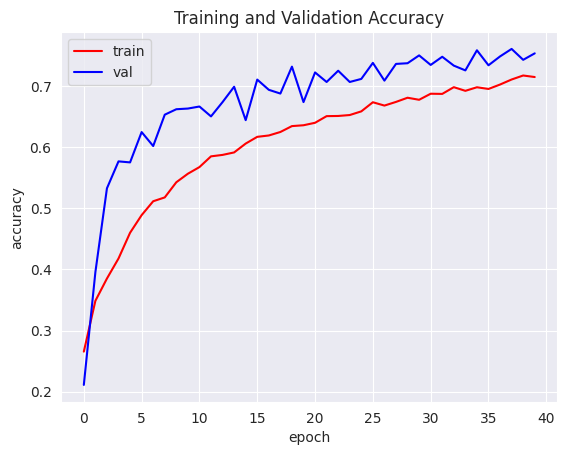

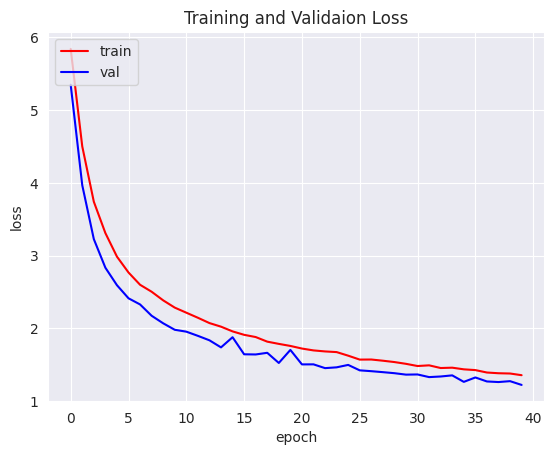

In [30]:
acc = history_32.history['accuracy']
val_acc = history_32.history['val_accuracy']
loss = history_32.history['loss']
val_loss = history_32.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

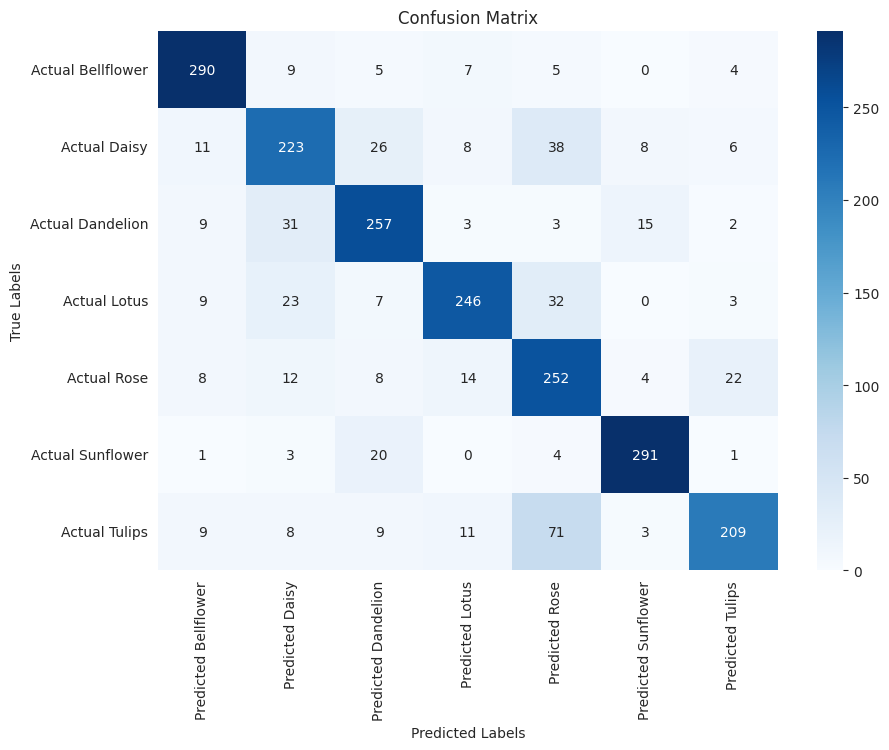



              precision    recall  f1-score   support

  bellflower     0.8605    0.9062    0.8828       320
       daisy     0.7217    0.6969    0.7091       320
   dandelion     0.7741    0.8031    0.7883       320
       lotus     0.8512    0.7688    0.8079       320
        rose     0.6222    0.7875    0.6952       320
   sunflower     0.9065    0.9094    0.9080       320
      tulips     0.8462    0.6531    0.7372       320

    accuracy                         0.7893      2240
   macro avg     0.7975    0.7893    0.7898      2240
weighted avg     0.7975    0.7893    0.7898      2240



In [31]:
test_generator.reset()

preds_1 = model_32.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1),
                  index=["Actual Bellflower", "Actual Daisy", "Actual Dandelion", "Actual Lotus", "Actual Rose", "Actual Sunflower", "Actual Tulips"],
                  columns=["Predicted Bellflower", "Predicted Daisy", "Predicted Dandelion", "Predicted Lotus", "Predicted Rose", "Predicted Sunflower", "Predicted Tulips"])

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_1,
                            target_names=['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulips'],
                            digits=4))

## Konversi Model

**savedmodel**

In [ ]:
model_32.save("/content/saved_model")

**TensorFlow Lite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_32)
tflite_model = converter.convert()

with open("/content/tflite/model_32.tflite", "wb") as f:
    f.write(tflite_model)

**TensorFlow.js**

In [ ]:
tfjs.converters.save_keras_model(model_32, "/content/tfjs_model")

## Inference (Optional)

In [ ]:
model_path = '/content/saved_model'
model = tf.keras.models.load_model(model_path)

In [ ]:
img_path = 'flowers/bellflower/0.jpg'
img = tf.keras.preprocessing.image.load_img(img_path)
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array_resized = resize_with_padding(img_array, 150, 150)
img_array_resized = img_array_resized / 255.0

img_array_resized = tf.expand_dims(img_array_resized, axis=0)

predictions = model_1.predict(img_array_resized)
print(predictions)